In [1]:
import numpy as np

### Tối ưu đồng thời hàm Sphere, Ackley, Rosenbrock

Sphere function:
$$
f(x) = \sum_{i=1}^n{x_i^2} \; \; with \;\;x \in R^n
$$ 
Ackley function:
$$
f(x) = -a.exp\Big(-b\sqrt{\frac{1}{d}\sum_{i=1}^d{x_i^2}}\Big)- exp(\frac{1}{d}\sum_{i=1}^dcos(cx_i))+a+exp(1)
$$
Rosenbrock function:
$$
f(x) = \sum_{i = 1}^{n - 1}[100(x_{i + 1} - x_i^2)^2 + (x_i - 1)^2]
$$

In [2]:
class sphere:
    def __init__(self, d):
        self.d = d

    def decode(self, x):
        return x[:self.d]

    def func(self, x):
        x = self.decode(x)
        return np.sum(x**2, axis = 0)

In [3]:
class ackley:
    a = 20
    b = 0.2
    c = 2*np.pi 
    def __init__(self, d):
        self.d = d

    def decode(self, x):
        return x[:self.d]

    def func(self, x):
        x = self.decode(x)
        return (-self.a * np.exp(-self.b*np.sqrt(np.average(x**2)))
        - np.exp(np.average(np.cos(self.c * x)))
        + self.a
        + np.exp(1)
        )
        

In [4]:
class rosenbrock:
    def __init__(self, d):
        self.d = d

    def decode(self, x):
        return x[:self.d]

    def func(self, x):
        x = self.decode(x)
        l = 100*np.sum((np.delete(x, 0, 0) - np.delete(x, -1, 0 )**2) ** 2)
        r = np.sum((np.delete(x, -1, 0) - 1) ** 2)
        return l + r


In [5]:
print(ackley(3).func(np.array([1, 2, 3])))
print(sphere(3).func(np.array([1, 2, 3])))
print(rosenbrock(3).func(np.array([1, 2, 3])))

7.0164536082694
14
201


In [6]:
print(ackley(3).func(np.array([0, 0, 0])))
print(sphere(3).func(np.array([0, 0, 0])))
print(rosenbrock(3).func(np.array([1, 1, 1])))

4.440892098500626e-16
0
0


In [7]:
def population_init(nums, d):
    return np.array([np.random.uniform(-100, 200, d) for i in range(nums)])
    
population_init(100, 2).shape

(100, 2)

In [8]:
def matrix_cost_pop(population, tasks = []):
    return np.array([np.apply_along_axis(t.func, 1, population) for t in tasks]).T

matrix_cost_pop(population_init(100, 2), [ackley(2), sphere(2)]).shape

(100, 2)

In [9]:
def matrix_rank_pop(cost_pop):
    return np.argsort(np.argsort(cost_pop, axis = 0), axis = 0) 

matrix_rank_pop(np.array([[10, 2], [2, 6], [23, 4]]))

array([[1, 0],
       [0, 2],
       [2, 1]])

In [10]:
def factorial_cost(child, skill_factor, tasks = []):
    return np.array([tasks[idx_task].func(child[idx_inds]) for idx_inds, idx_task in enumerate(skill_factor)])


In [11]:
def factorial_rank(f_cost, skill_factor, num_tasks):
    res = np.zeros_like(skill_factor)
    for i in range (num_tasks):
        inds = np.where(skill_factor == i)
        res[inds] = np.argsort(np.argsort(f_cost[inds]))
    return res

In [12]:
def sbx_crossover(pa, pb):
    nc = 10
    u = np.random.uniform()
    if u <= 0.5:
        beta = (2*u)**(1/(nc +1))
    else:
        beta = (1/(2 * (1 - u)))**(1 / (1 + nc))
        
    c1 = 0.5*((1 + beta) * pa + (1 - beta) * pb)
    c2 = 0.5*((1 - beta) * pa + (1 + beta) * pb)
    return c1, c2

sbx_crossover(np.array([1, 2, 3]), np.array([7, 4, 3]))

(array([0.85171062, 1.95057021, 3.        ]),
 array([7.14828938, 4.04942979, 3.        ]))

In [13]:
def polynomial_mutate(p):
    nm = 10
    u = np.random.rand()
    
    if u <= 0.5:
        delta_l = (2*u)**(1/(nm + 1)) - 1
        return p + delta_l * p
    
    else: 
        delta_r = 1 - (2*(1-u))**(1/(nm + 1))
        return p + delta_r * (1 - p)

polynomial_mutate(np.array([1, 2, 3]))

array([1.        , 1.96331821, 2.92663643])

In [14]:
def mefa(num_epochs, num_inds, tasks = [], rmp = 0.1):
    max_d = 0
    for t in tasks:
        if max_d < t.d:
            max_d = t.d

    # initial population
    population = population_init(num_inds, max_d)

    # matrix cost and rank
    full_cost = matrix_cost_pop(population, tasks)
    full_rank = matrix_rank_pop(full_cost)
    
    #skill factor, factorial cost, factorial rank
    skill_factor = np.argmin(full_rank, axis = 1)
    f_cost = np.array([full_cost[idx, skill_factor[idx]] for idx in range(num_inds)])

    history = np.empty((0, len(tasks)), np.float)

    for epoch in range(num_epochs):
        child = np.empty((0, population.shape[1]))
        child_skill_factor = np.empty((0, 1), int)

        while len(child) < num_inds:
            [idx_a, idx_b] = np.random.randint(num_inds, size = 2)
            [pa, pb], [skf_a, skf_b] = population[[idx_a, idx_b]], skill_factor[[idx_a, idx_b]]

            if skf_a == skf_b or np.random.uniform() < rmp :
                ca, cb = sbx_crossover(pa, pb)
                
                child = np.append(child, [ca, cb], axis = 0)
                child_skill_factor = np.append(child_skill_factor, [np.random.choice([skf_a, skf_b]) for i in range (2)])
            
            else:
                ca, cb = polynomial_mutate(pa), polynomial_mutate(pb)
                
                child = np.append(child, [ca, cb], axis = 0)
                child_skill_factor = np.append(child_skill_factor, [skf_a, skf_b])
        

        child_fcost = factorial_cost(child, child_skill_factor, tasks)

        #merge population and child
        large_pop = np.append(population, child, axis = 0)
        large_fcost = np.append(f_cost, child_fcost, axis = 0)
        large_skill_factor = np.append(skill_factor, child_skill_factor, axis = 0)

        large_scalar_fitness = 1/factorial_rank(large_fcost, large_skill_factor, len(tasks))
        
        #selected individuals 
        selected_inds = np.argsort(-large_scalar_fitness)[:num_inds] 
        
        #update population
        population = large_pop[selected_inds]
        skill_factor = large_skill_factor[selected_inds]
        f_cost = large_fcost[selected_inds]

        # save history
        history = np.append(history, [[np.min(f_cost[np.where(skill_factor == idx)[0]]) for idx in range (len(tasks))]], axis = 0)
        
        print('Epoch [{}/{}], func_val: {}'
            .format(epoch + 1, num_epochs, [np.min(f_cost[np.where(skill_factor == idx)[0]]) for idx in range (len(tasks))])
        )
        # print('Epoch [{}/{}], func_val: {}'
        #     .format(epoch + 1, num_epochs, history[-1])
        # )

    sol_idx = [np.argmin(f_cost[np.where(skill_factor == idx)]) for idx in range (len(tasks))]
    return [population[np.where(skill_factor == idx)][sol_idx[idx]] for idx in range(len(tasks))], history

In [15]:
tasks = [sphere(30), ackley(50), rosenbrock(20), rosenbrock(30)]
sol, his = mefa(num_epochs= 200, num_inds= 100, tasks= tasks, rmp= 0.5)

/tmp/ipykernel_94225/24019857.py:48: RuntimeWarning: divide by zero encountered in true_divide
  large_scalar_fitness = 1/factorial_rank(large_fcost, large_skill_factor, len(tasks))


Epoch [1/200], func_val: [132259.99304817515, 21.490903753051068, 101480348206.88857, 192156373818.7251]
Epoch [2/200], func_val: [106276.43307825604, 21.490903753051068, 99820587425.35014, 191005908249.08716]
Epoch [3/200], func_val: [76907.34235409705, 21.427493088010614, 45903251829.32701, 112268790499.47078]
Epoch [4/200], func_val: [55180.887613148996, 21.427493088010614, 31876225347.628178, 110700912315.59962]
Epoch [5/200], func_val: [47782.80659769481, 21.427493088010614, 31876225347.628178, 71191322225.5349]
Epoch [6/200], func_val: [47782.80659769481, 21.427493088010614, 16395598946.278698, 58624340812.52842]
Epoch [7/200], func_val: [42003.84588286341, 21.427493088010614, 7072348345.332445, 35535951139.34287]
Epoch [8/200], func_val: [29063.68082105085, 21.427493088010614, 6096093327.069991, 16543925066.76684]
Epoch [9/200], func_val: [23944.6610023275, 21.427493088010614, 3600436346.284339, 4501041267.734071]
Epoch [10/200], func_val: [23944.6610023275, 21.427493088010614, 

In [16]:
sol[0].shape

(50,)

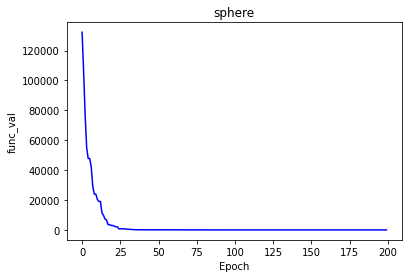

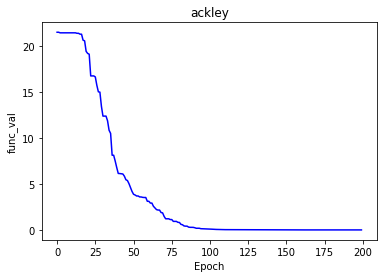

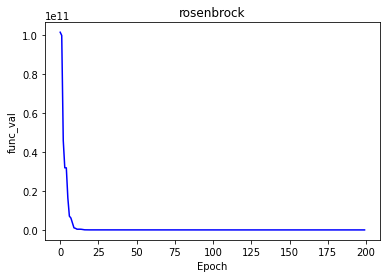

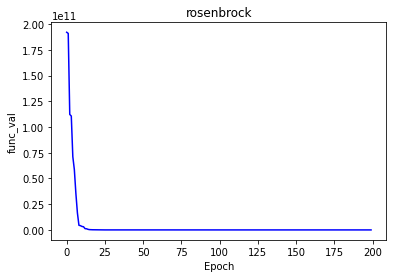

In [17]:
import matplotlib.pyplot as plt

for i in range (his.shape[1]):
    plt.plot(np.arange(len(his)), his[:, i], "blue")
    
    plt.title(tasks[i].__class__.__name__)
    plt.xlabel("Epoch")
    plt.ylabel("func_val")
    plt.show()